# COVID-19 en Chile
> Total de casos confirmados, fallecidos confirmados, pacientes en UCI por región.

- toc: true 
- badges: true
- comments: true
- author: Alonso Silva Allende
- categories: [jupyter]
- image: images/chart-preview.png

In [1]:
#hide
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
plt.style.use('ggplot')

# Evolución de casos confirmados por región

In [2]:
#hide
data_raw = pd.read_csv(
    "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo.csv",
    index_col='Region')

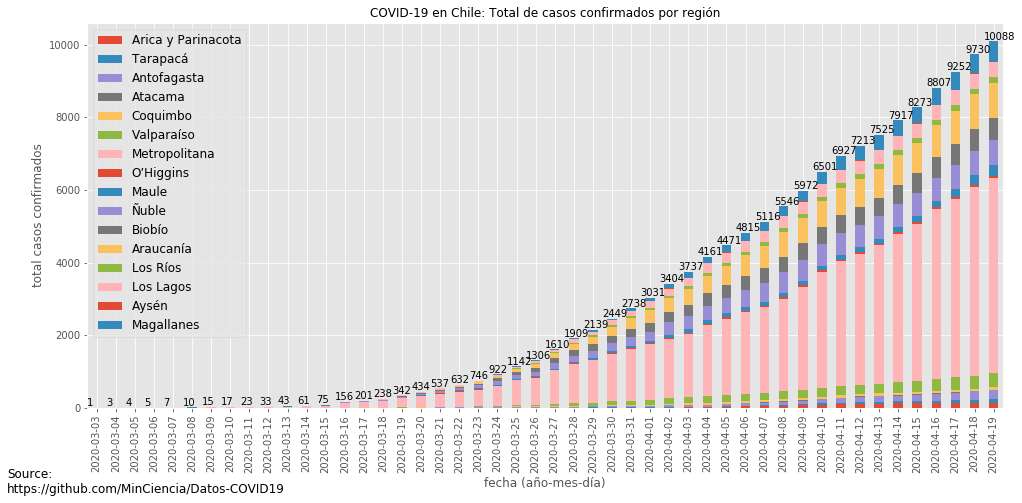

In [3]:
#hide_input
fig, ax = plt.subplots(figsize=(14,7))
data_raw[:-1].T.plot(ax=ax, kind="bar", stacked=True)
for i, val in enumerate(data_raw.loc['Total']):
    ax.text(i-0.5, val+50, str(int(val)), fontsize=10)
plt.legend(fontsize='large')
ax.set_title(f'COVID-19 en Chile: Total de casos confirmados por región', fontsize='large')
ax.set_xlabel(f'fecha (año-mes-día)', fontsize='large')
ax.set_ylabel(f'total casos confirmados', fontsize='large')
fig.tight_layout()
plt.annotate('Source:\nhttps://github.com/MinCiencia/Datos-COVID19', (0,0), (-80,-60), fontsize='large', xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

# Evolución de fallecidos confirmados por región

In [4]:
#hide
data = pd.DataFrame()
data_raw = pd.read_csv(
    "https://raw.githubusercontent.com/alonsosilvaallende/Datos-COVID19/master/output/producto4/2020-03-24-CasosConfirmados-totalRegional.csv",
    index_col='Region')
data['2020-03-24'] = data_raw['Fallecidos']

In [5]:
#hide
first_death_date = '2020-03-24'
today = '2020-04-19'
total_days = (pd.to_datetime(today)-pd.to_datetime(first_death_date)).days

In [6]:
#hide
for i in np.arange(total_days+1):
  date = (pd.to_datetime(first_death_date)+pd.DateOffset(i)).strftime('%Y-%m-%d')
  s = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto4/" + date + "-CasosConfirmados-totalRegional.csv"
  data_by_date = pd.read_csv(s)
  if 'Fallecidos' in data_by_date.columns:
    data[date] = data_by_date["Fallecidos"].values
  elif 'Casos fallecidos' in data_by_date.columns:
    data[date] = data_by_date["Casos fallecidos"].values
  else:
    data[date] = data_by_date[" Casos fallecidos"].values

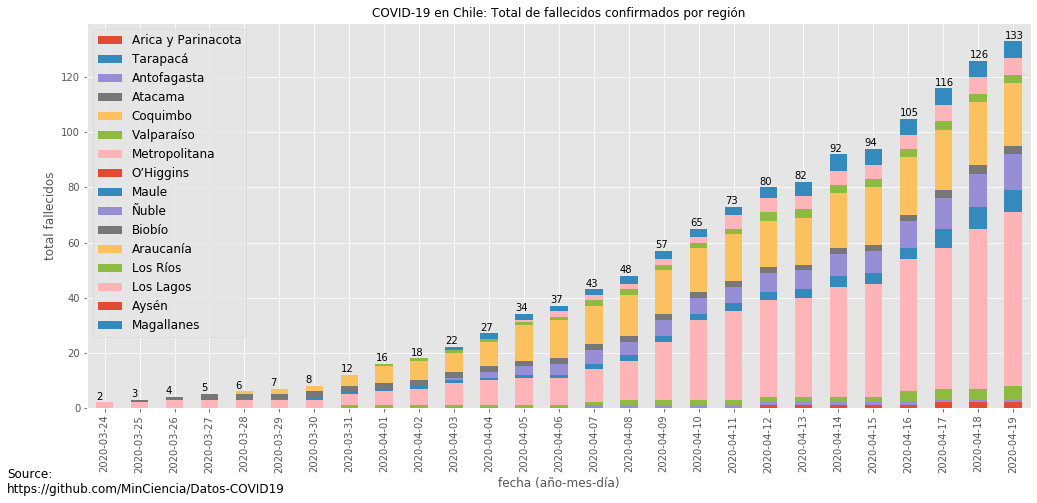

In [7]:
#hide_input
fig, ax = plt.subplots(figsize=(14,7))
data[:-1].T.plot(ax=ax, kind="bar", stacked=True)
for i, val in enumerate(data.loc['Total']):
    ax.text(i-0.25, val+1, str(int(val)), fontsize=10)
plt.legend(fontsize='large')
ax.set_title(f'COVID-19 en Chile: Total de fallecidos confirmados por región', fontsize='large')
ax.set_xlabel(f'fecha (año-mes-día)', fontsize='large')
ax.set_ylabel(f'total fallecidos', fontsize='large')
fig.tight_layout()
plt.annotate('Source:\nhttps://github.com/MinCiencia/Datos-COVID19', (0,0), (-80,-60), fontsize='large', xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

# Evolución de pacientes en UCI por región

In [15]:
#hide
data_raw = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto8/UCI.csv',
    index_col='Region')
data_raw = data_raw.drop(columns='Codigo region')
data_raw.loc['Total'] = data_raw.sum(axis=0)
data_raw = data_raw.drop(columns='Poblacion')

In [16]:
#hide
data_raw = data_raw.drop("Total")

In [10]:
#hide
data = pd.DataFrame()
i = 0
for date in data_raw.keys():
    for n, region in enumerate(data_raw.index):
        data[i] = date, region, data_raw[date].loc[region], n
        i += 1

In [33]:
#hide
data_raw = data_raw.reset_index()

In [34]:
#hide
regiones = data_raw['Region'].values

In [11]:
#hide
data = data.T

In [12]:
#hide
data = data.rename(columns={0: "date", 1: "region", 2: "pacientes", 3: "codigo region"})

In [13]:
#hide
data["pacientes"] = data["pacientes"].astype(int)

In [27]:
#hide_input
bars = alt.Chart(data).mark_bar().encode(
    x='date:O',
    y=alt.Y('pacientes'),
    color=alt.Color('region:N', sort=regiones),
    order=alt.Order(
    # Sort the segments of the bars by this field
    'codigo region',
    sort='descending'
    )
    ).properties(
    title='COVID-19 en Chile: Pacientes en UCI por región'
)
    
# text = bars.mark_text(
#     align='left',
#     baseline='middle',
#     dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text='sum(pacientes):Q'
# )

bars.configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='gray'
)

bars.properties(width=600, height=300)
# (bars + text).properties(width=600, height=300)

alt.Chart(...)

Fuente: [Ministerio de Ciencia](https://github.com/MinCiencia/Datos-COVID19)

In [35]:
#hide
# fig, ax = plt.subplots(figsize=(14,7))
# data_raw[:-1].T.plot(ax=ax, kind="bar", stacked=True)
# for i, val in enumerate(data_raw.loc['Total']):
#   ax.text(i-0.2, val+4, f"{val}", fontsize='x-large')

# # Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# # Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-large')

# ax.tick_params(labelsize='large')
# ax.set_title(f'COVID-19 en Chile: Pacientes en UCI por región', fontsize='x-large')
# ax.set_xlabel(f'fecha (año-mes-día)', fontsize='x-large')
# ax.set_ylabel(f'pacientes en UCI', fontsize='x-large')
# fig.tight_layout()
# plt.annotate('Source:\nhttps://github.com/MinCiencia/Datos-COVID19', (0,0), (-100,-80), fontsize='x-large', xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()

# Fallecidos confirmados por región

In [29]:
#hide
data_raw = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto4/2020-04-19-CasosConfirmados-totalRegional.csv',
    index_col='Region')

In [30]:
#hide
data_raw = data_raw[data_raw['Fallecidos']>0]
data_raw = data_raw.drop('Total')

In [32]:
#hide_input
bars = alt.Chart(data_raw.reset_index()).mark_bar().encode(
    x = alt.X('Fallecidos:Q', scale=alt.Scale(domain=(0, 65)), axis=alt.Axis(title='Fallecidos confirmados')),
    y = alt.Y('Region:N', sort='-x')
).properties(
    title='COVID-19 en Chile: Fallecidos confirmados por región'
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Fallecidos:Q'
)

bars.configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='gray'
)

(bars + text).properties(width=600, height=300)

alt.LayerChart(...)

Fuente: [Ministerio de Ciencia](https://github.com/MinCiencia/Datos-COVID19)

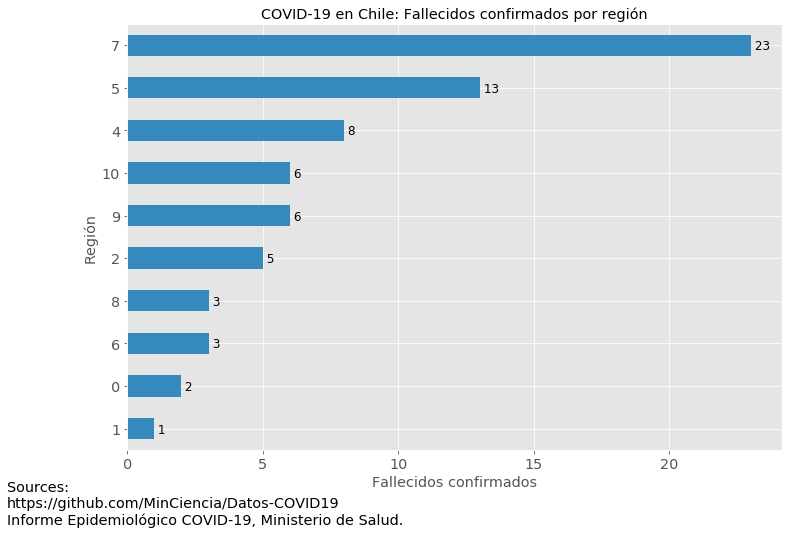

In [36]:
#hide
data_raw = data_raw.sort_values(by='Fallecidos', ascending=True)
fig, ax = plt.subplots(figsize=(10,7))
data_raw['Fallecidos'][:-1].plot(kind='barh', ax=ax, color='C1', fontsize='x-large')
for i, val in enumerate(data_raw['Fallecidos'][:-1]):
    ax.text(val, i-0.1, f" {val:.0f}", fontsize='large')
ax.set_title(f'COVID-19 en Chile: Fallecidos confirmados por región', fontsize='x-large')
ax.set_xlabel(f'Fallecidos confirmados', fontsize='x-large')
ax.set_ylabel(f'Región', fontsize='x-large')
# plt.xlim(0,135)
fig.tight_layout()
plt.annotate('Sources:\nhttps://github.com/MinCiencia/Datos-COVID19\nInforme Epidemiológico COVID-19, Ministerio de Salud.', (0,0), (-120,-30), fontsize='x-large', xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

# Tasa de fallecidos por región
> Tasa de fallecidos = fallecidos por cada 1 millón de habitantes

In [38]:
#hide
data_raw = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto4/2020-04-19-CasosConfirmados-totalRegional.csv',
    index_col='Region')

In [39]:
#hide
tests_raw = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto7/PCR.csv',
    index_col='Region')
tests_raw = tests_raw.fillna(0)

In [40]:
#hide
tests_total = pd.Series(dtype='float64')
for date in tests_raw.columns:
  tests_raw[date] = tests_raw[date].apply(lambda x: 0 if x=='-' else x)
  tests_raw[date] = tests_raw[date].astype(int)
  tests_total[date] = np.sum(tests_raw[date])

In [41]:
#hide
tests_raw.loc['Total'] = tests_total

In [42]:
#hide
death_rate = 1000000*data_raw['Fallecidos']/tests_raw['Poblacion'].values
death_rate = death_rate.sort_values(ascending=True)
death_rate = death_rate[death_rate>0]

In [43]:
#hide
death_rate.reset_index()

,Region,Fallecidos
0,Antofagasta,1.445392
1,Biobio,1.803214
2,Valparaiso,2.550799
3,Los Lagos,6.730683
4,Total,6.835126
5,Maule,7.067519
6,Los Rios,7.392167
7,Metropolitana,7.753777
8,Arica y Parinacota,7.933045
9,Araucania,22.674776


In [44]:
#hide_input
bars = alt.Chart(death_rate.reset_index()).mark_bar().encode(
    x = alt.X('Fallecidos:Q', scale=alt.Scale(domain=(0, 36.0)), axis=alt.Axis(title='Tasa de fallecidos confirmados')),
    y = alt.Y('Region:N', sort='-x')
).properties(
    title='COVID-19 en Chile: Tasa de fallecidos confirmados por región'
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('Fallecidos:Q', format=',.1f')
)

bars.configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='gray'
)

(bars + text).properties(width=600, height=300)

alt.LayerChart(...)

Fuente: [Ministerio de Ciencia](https://github.com/MinCiencia/Datos-COVID19)

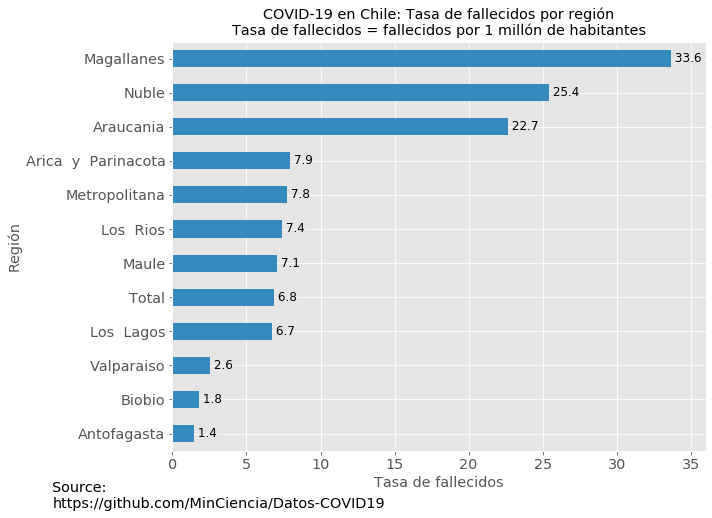

In [45]:
#hide
fig, ax = plt.subplots(figsize=(10,7))
death_rate.plot(kind='barh', ax=ax, color='C1', fontsize='x-large')
for i, val in enumerate(death_rate):
  ax.text(val, i-0.1, f" {val:.1f}", fontsize='large')
ax.set_title(f'COVID-19 en Chile: Tasa de fallecidos por región\nTasa de fallecidos = fallecidos por 1 millón de habitantes', fontsize='x-large')
ax.set_xlabel(f'Tasa de fallecidos', fontsize='x-large')
ax.set_ylabel(f'Región', fontsize='x-large')
plt.xlim(0,36)
fig.tight_layout()
plt.annotate('Source:\nhttps://github.com/MinCiencia/Datos-COVID19', (0,0), (-120,-30), fontsize='x-large', xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

# Tasa de letalidad por región
> Tasa de letalidad = fallecidos confirmados / casos confirmados (en porcentaje)

In [46]:
#hide
CFR = data_raw['Fallecidos']/data_raw['Casos  totales']*100
CFR = CFR.sort_values(ascending=True)
CFR = CFR[CFR>0]

In [47]:
#hide
CFR = CFR.reset_index()
CFR['Tasa de letalidad'] = CFR[0]
CFR = CFR.drop(columns=0)

In [48]:
#hide_input
bars = alt.Chart(CFR).mark_bar().encode(
    x = alt.X('Tasa de letalidad:Q', axis=alt.Axis(title='Tasa de letalidad')),
    y = alt.Y('Region:N', sort='-x')
).properties(
    title='COVID-19 en Chile: Tasa de letalidad por región'
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('Tasa de letalidad:Q', format=',.1f')
)

bars.configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='gray'
)

(bars + text).properties(width=600, height=300)

alt.LayerChart(...)

Fuente: [Ministerio de Ciencia](https://github.com/MinCiencia/Datos-COVID19)

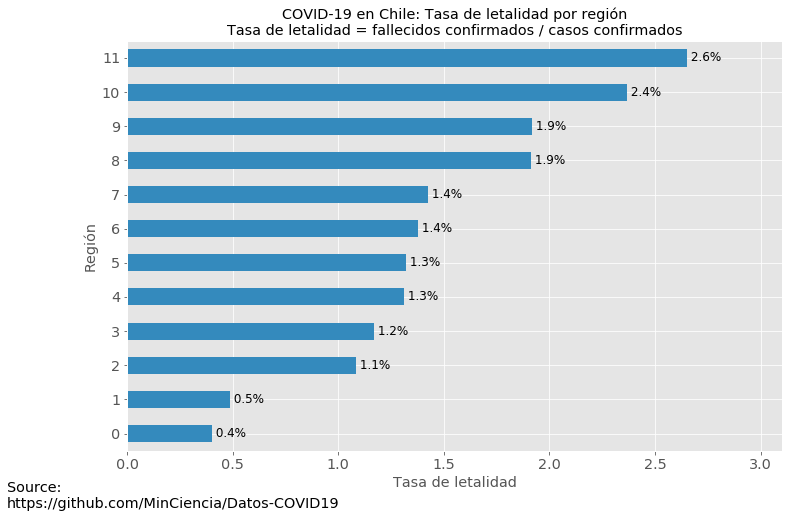

In [49]:
#hide
fig, ax = plt.subplots(figsize=(10,7))
CFR['Tasa de letalidad'].plot(kind='barh', ax=ax, color='C1', fontsize='x-large')
for i, val in enumerate(CFR['Tasa de letalidad']):
  ax.text(val, i-0.1, f" {val:.1f}%", fontsize='large')
ax.set_title(f'COVID-19 en Chile: Tasa de letalidad por región\nTasa de letalidad = fallecidos confirmados / casos confirmados', fontsize='x-large')
ax.set_xlabel(f'Tasa de letalidad', fontsize='x-large')
ax.set_ylabel(f'Región', fontsize='x-large')
plt.xlim(0,3.1)
fig.tight_layout()
plt.annotate('Source:\nhttps://github.com/MinCiencia/Datos-COVID19', (0,0), (-120,-30), fontsize='x-large', xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()